In [1]:
__author__ = 'Alice Jacques <alice.jacques@noirlab.edu>, Stephanie Juneau <stephanie.juneau@noirlab.edu>, SPARCL team'
__version__ = '20241212' # yyyymmdd
__datasets__ = ['sdss_dr16', 'boss_dr16', 'desi_edr', 'desi_dr1']  
__keywords__ = ['sparcl', 'spectroscopy', 'HowTo', 'sdss spectra', 'desi spectra', 'tutorial']

# How to use SPARCL at NERSC
## SPectra Analysis and Retrievable Catalog Lab (SPARCL)
Alice Jacques (NOIRLab), Stéphanie Juneau (NOIRLab), Benjamin Weaver (NOIRLab), Steve Pothier (NOIRLab), Adam Bolton (SLAC) and the SPARCL team

### Table of contents
* [Goals & Summary](#goalssummary)
* [Disclaimer & attribution](#disclaimer)
* [If necessary, install the most recent version of the SPARCL Client](#install)
* [Imports and setup](#imports)
* [Authentication for SPARCL](#auth_sparcl)
* [Data sets available in SPARCL](#datasets)
* [Get default field names](#defaultfieldnames)
* [Get all field names](#allfieldnames)
* [Data discovery I: using SPARCL's <tt>client.find()</tt> method](#datadiscoveryI)
* [Data discovery II: using the DESI DR1 database](#datadiscoveryII)
* [Retrieve records by <tt>specid</tt> using <tt>client.retrieve_by_specid()</tt>](#retrieve_specid)
* [Reorder spectrum records](#reorder)
* [Convert retrieved output to a Spectrum1D object](#convert)
* [Plot spectra](#plot)
* [Additional acknowledgments](#additionalacknowledgments)

<a class="anchor" id="goalssummary"></a>
## Goals & Summary 

SPARCL (SPectra Analysis and Retrievable Catalog Lab) is an online service for discovery and retrieval of one-dimensional optical-infrared spectra. SPARCL is designed to work for large survey datasets containing many millions of spectra, and to provide access to multiple different data sets through common methods. For more information, see the [SPARCL User Guide](https://astrosparcl.datalab.noirlab.edu/static/SPARCLUserManual.pdf).

This notebook provides a basic introduction to using the SPARCL client (or sparclclient) to find and retrieve spectroscopic data within a Python notebook context. The sparclclient connects to the SPARCL server at [NSF NOIRLab](https://noirlab.edu/public/) and provides access to the contents of the SPARCL database.

To see the current data sets and number of spectra available in the SPARCL database, please visit the [SPARCL summary page](https://astrosparcl.datalab.noirlab.edu/sparc/).

To get the latest sparclclient documentation, visit the [sparclclient readthedocs site](https://sparclclient.readthedocs.io/en/latest/).

Feedback on SPARCL (questions, comments, science use cases, feature requests, bug reports, confusing error messages, etc.) can be submitted to datalab-spectro@noirlab.edu. For bug reports and confusing error messages, it's helpful if you include: a log of *what you did*, *the result you got*, and *the result you expected*.

See our science use-case notebooks that use SPARCL:
- [Introduction to DESI Early Data Release (EDR) at the Astro Data Lab](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/DESI/01_Intro_to_DESI_EDR.ipynb)
- [Comparing SDSS and DESI spectra using SPARCL](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/DESI/02_DESI_EDR_SDSS_Comparison.ipynb)
- [Stacking SDSS Spectra of Galaxies Selected from the BPT Diagram](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/EmLineGalaxies/01_EmLineGalaxies_SpectraStack.ipynb)
- [Multi-wavelength Image Cutouts and SDSS Spectra of Active Galaxies with Extreme Emission-Line Ratios](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/EmLineGalaxies/02_EmLineGalaxies_Outliers.ipynb)

And our other How-To notebooks that use SPARCL:
- [Obtain spectra with SPARCL and plot them with Jdaviz](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/Plot_SPARCL_Spectra_with_Jdaviz.ipynb)
- [Obtain spectra with SPARCL and plot them with prospect](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/Plot_SPARCL_Spectra_with_Prospect.ipynb)

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab and/or SPARCL constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
Researchers are required to acknowlege the source of the data (DESI and/or SDSS) in their papers following each survey's guidelines. If you use **SPARCL** in your published research, also include this text in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL), which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you publish in an AAS journal, please add `\software{SPARCL}` and cite:
* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576 

If you are using the Astro Data Lab in your research, also see the [Additional acknowledgments](#additionalacknowledgments) section. The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="install"></a>
### If necessary, install the most recent version of the SPARCL Client:
If you are using the Astro Data Lab Jupyter notebook server, you do not need to run this cell.

<div class="alert alert-block alert-info">
<b>Reminder:</b> After installing the most recent version, please restart your kernel
</div>

In [2]:
## Uncomment the following only if SPARCL client is not already installed
#!pip install --upgrade sparclclient

<a class="anchor" id="imports"></a>
## Imports and setup

In [3]:
# SPARCL imports
from sparcl.client import SparclClient

# 3rd party imports
import numpy as np
import astropy.units as u
from astropy.table import Table
from specutils import Spectrum1D
from astropy.nddata import InverseVariance
from astropy.convolution import convolve, Gaussian1DKernel
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from getpass import getpass

# For NERSC specprod database access (other notebook)
from desiutil.log import get_logger, DEBUG
import specprodDB.load as db

# plots default setup
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (14,8)

In [4]:
# NERSC database logger
db.log = get_logger()

#### We now create a SPARCL client instance:

In [5]:
client = SparclClient()
client

(sparclclient:1.2.3, api:12.0, https://astrosparcl.datalab.noirlab.edu/sparc, client_hash=, verbose=False, connect_timeout=1.1, read_timeout=5400.0)

<a class="anchor" id="auth_sparcl"></a>
# Authentication for SPARCL
All public SPARCL data sets can be accessed without explicitly logging in. However, some data sets are private and can only be accessed by authorized users. If you are an authorized user and wish to login to SPARCL, un-comment the cell below and enter your NOIRLab CSDC SSO user name and password. If you need to create an account, sign-up at https://sso.csdc.noirlab.edu/account/signup/. If you encounter an issue, email datalab-spectro@noirlab.edu with your First Name, Last Name, and Email Address (the same one you used to create your NOIRLab CSDC SSO account).

To logout of SPARCL after a session, use:
```
client.logout()
```

For assistance with SPARCL authentication/authorization please contact us at datalab-spectro@noirlab.edu

In [6]:
client.login(input("Enter SSO user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

Enter SSO user name: (+ENTER)  stephanie.juneau@noirlab.edu
Enter password: (+ENTER)  ········


Logged in successfully with email='stephanie.juneau@noirlab.edu'


#### View which data sets you have access to:
**Note:** if you are not logged in or if your SSO user name is not in the authorized list of SPARCL users, you will only see public data sets

In [7]:
client.authorized

{'Loggedin_As': 'stephanie.juneau@noirlab.edu',
 'Authorized_Datasets': {'BOSS-DR16', 'DESI-DR1', 'DESI-EDR', 'SDSS-DR16'}}

<a class="anchor" id="datasets"></a>
## Data sets available in SPARCL
List all currently available data sets from the server/url associated with client

In [8]:
client.all_datasets

{'BOSS-DR16', 'DESI-DR1', 'DESI-EDR', 'SDSS-DR16', 'SDSS-DR17-test'}

<a class="anchor" id="defaultfieldnames"></a>
## Get default field names
Gets fields tagged as 'default' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'default' fields across all datasets currently available in the SPARC database.

In [9]:
client.get_default_fields?

Signature: client.get_default_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'default' that are in DATASET_LIST.
These are the fields used for the DEFAULT value of the include
parameter of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get the default fields. Defaults to None, which
        will return the intersection of default fields in all
        data sets hosted on the SPARCL database.

Returns:
    List of fields tagged as 'default' from DATASET_LIST.

Example:
    >>> client = SparclClient()
    >>> client.get_default_fields()
    ['dec', 'flux', 'ra', 'sparcl_id', 'specid', 'wavelength']
File:      ~/.local/lib/python3.10/site-packages/sparcl/client.py
Type:      method

In [10]:
client.get_default_fields()

['dec', 'flux', 'ra', 'sparcl_id', 'specid', 'wavelength']

<a class="anchor" id="allfieldnames"></a>
## Get all field names
Gets fields tagged as 'all' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'all' fields across all datasets currently available in the SPARC database.

In [11]:
client.get_all_fields?

Signature: client.get_all_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'all' that are in DATASET_LIST.
These are the fields used for the ALL value of the include parameter
of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get all fields. Defaults to None, which
        will return the intersection of all fields in all
        data sets hosted on the SPARCL database.

Returns:
    List of fields tagged as 'all' from DATASET_LIST.

Example:
    >>> client = SparclClient()
    >>> client.get_all_fields()
    ['data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'flux', 'instrument', 'ivar', 'mask', 'model', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'site', 'sparcl_id', 'specid', 'specprimary', 'spectype', 'survey', 'targetid', 'telescope', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']
File:      ~/.local/lib/python3.10/site-packages/sparcl/client.py
Type:      method

In [12]:
print(sorted(client.get_all_fields()))

['data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'flux', 'instrument', 'ivar', 'mask', 'model', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'site', 'sparcl_id', 'specid', 'specprimary', 'spectype', 'survey', 'targetid', 'telescope', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']


In [14]:
print(sorted(client.get_all_fields(dataset_list=['SDSS-DR16', 'BOSS-DR16'])))

['ancillary_target1', 'ancillary_target2', 'anyandmask', 'anyormask', 'bluefiber', 'boss_specobj_id', 'boss_target1', 'boss_target2', 'calibflux', 'calibflux_ivar', 'chi68p', 'chunk', 'class_noqso', 'class_person', 'comments_person', 'cx', 'cy', 'cz', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'deredsn2', 'designid', 'dof', 'eboss_target0', 'eboss_target1', 'eboss_target2', 'eboss_target_id', 'elodie_bv', 'elodie_dof', 'elodie_feh', 'elodie_filename', 'elodie_logg', 'elodie_object', 'elodie_rchi2', 'elodie_sptype', 'elodie_teff', 'elodie_z', 'elodie_z_err', 'elodie_z_modelerr', 'exptime', 'fiberid', 'firstrelease', 'flux', 'fluxobjid', 'fracnsighi', 'fracnsiglo', 'fracnsigma', 'instrument', 'ivar', 'lambda_eff', 'legacy_target1', 'legacy_target2', 'marvels_target1', 'marvels_target2', 'mask', 'mjd', 'model', 'npoly', 'nspecobs', 'nturnoff', 'objid', 'plate', 'plateid', 'platequality', 'platerun', 'platesn2', 'primtarget', 'programname', 'ra', 'rchi2', 'rchi2dif

In [15]:
fields_EDR = sorted(client.get_all_fields(dataset_list=['DESI-EDR']))

print(fields_EDR)

['bgs_target', 'chi2', 'cmx_target', 'coadd_fiberstatus', 'coadd_numexp', 'coadd_numnight', 'coadd_numtile', 'coeff', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'deltachi2', 'desi_target', 'exptime', 'fa_target', 'fa_type', 'firstnight', 'flux', 'healpix', 'instrument', 'ivar', 'lastnight', 'mask', 'mean_delta_x', 'mean_delta_y', 'mean_fiber_dec', 'mean_fiber_ra', 'mean_mjd', 'mean_psf_to_fiber_specflux', 'model', 'mws_target', 'ncoeff', 'npixels', 'numobs_init', 'objtype', 'obsconditions', 'plate_dec', 'plate_ra', 'pmdec', 'pmra', 'priority_init', 'program', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'ref_epoch', 'rms_delta_x', 'rms_delta_y', 'scnd_target', 'site', 'sparcl_id', 'specid', 'specprimary', 'spectype', 'spgrpval', 'std_fiber_dec', 'std_fiber_ra', 'subpriority', 'subtype', 'survey', 'sv1_bgs_target', 'sv1_desi_target', 'sv1_mws_target', 'sv1_scnd_target', 'sv2_bgs_target', 'sv2_desi_target', 'sv2_mws_target', 'sv2_scnd_target', 'sv3_bgs_t

In [16]:
fields_DR1 = sorted(client.get_all_fields(dataset_list=['DESI-DR1']))

print(fields_DR1)

['bgs_target', 'chi2', 'cmx_target', 'coadd_fiberstatus', 'coadd_numexp', 'coadd_numnight', 'coadd_numtile', 'coeff', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'deltachi2', 'desi_target', 'desiname', 'exptime', 'fa_target', 'fa_type', 'flux', 'healpix', 'instrument', 'ivar', 'main_nspec', 'main_primary', 'mask', 'mean_delta_x', 'mean_delta_y', 'mean_fiber_dec', 'mean_fiber_ra', 'mean_mjd', 'mean_psf_to_fiber_specflux', 'model', 'mws_target', 'ncoeff', 'npixels', 'numobs_init', 'objtype', 'obsconditions', 'plate_dec', 'plate_ra', 'pmdec', 'pmra', 'priority_init', 'program', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'ref_epoch', 'rms_delta_x', 'rms_delta_y', 'scnd_target', 'site', 'sparcl_id', 'specid', 'specprimary', 'spectype', 'spgrpval', 'std_fiber_dec', 'std_fiber_ra', 'subpriority', 'subtype', 'survey', 'sv1_bgs_target', 'sv1_desi_target', 'sv1_mws_target', 'sv1_scnd_target', 'sv2_bgs_target', 'sv2_desi_target', 'sv2_mws_target', 'sv2_scnd_targ

In [17]:
## Fields in EDR that are not in DR1
set(fields_EDR).difference(fields_DR1)

{'firstnight', 'lastnight'}

In [18]:
## Fields in DR1 that are not in EDR
set(fields_DR1).difference(fields_EDR)

{'desiname', 'main_nspec', 'main_primary'}

<a class="anchor" id="datadiscoveryI"></a>
## Data discovery I: using SPARCL's `client.find()` method
The first way you can discover your data is by using SPARCL's `client.find()` method, which allows you to find records in the SPARCL database based on certain parameters passed to the function. Only Core fields may be in the `outfields` and `constraints` parameters. The descriptions for all fields, including Core fields, is located [here](https://astrosparcl.datalab.noirlab.edu/sparc/sfc/). The SPARCL Core fields constraint types are:


| Field name       | Constraint type | Example |
|:----------------|:---------------|:-------|
| data_release     | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['DESI-EDR', 'BOSS-DR16', 'SDSS-DR16']
| datasetgroup     | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['DESI', 'SDSS_BOSS']
| dateobs_center   | Range of values | ['2013-03-14T10:16:17Z',<br>'2014-05-24T12:10:00Z']
| dec              | Range of values | [2.03, 7.76]
| exptime          | Range of values | [3603.46, 3810.12]
| instrument       | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['SDSS', 'BOSS', 'DESI']
| ra               | Range of values (may not<br>"wrap" around RA=0) | [44.53, 47.96]
| redshift         | Range of values | [0.5, 0.9]
| redshift_err     | Range of values | [0.000225, 0.000516]
| redshift_warning | List of values  | [0, 3, 5]
| sparcl_id               | List of values (but not<br>intended for data discovery) | ['00001658-460c-4da1-987d-e493d8c9b89b',<br>'000017b6-56a2-4f87-8828-3a3409ba1083']
| site             | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) |  ['apo', 'kpno']
| specid           | List of values | [6988698046080241664, 6971782884823945216]
| spectype         | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['GALAXY', 'STAR', 'QSO']
| specprimary      | List of values (but typically<br>would only include 1 if<br>being used for data<br>discovery constraints) | [1]
| targetid         | List of values | [1237679502171374316, 1237678619584692841]
| telescope        | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['sloan25m', 'kp4m']
| wavemin          | Range of values | [3607, 3608]
| wavemax          | Range of values | [10363, 10364]

In [19]:
client.find?

Signature:
client.find(
    outfields=None,
    *,
    constraints={},
    limit=500,
    sort=None,
    verbose=None,
)
Docstring:
Find records in the SPARCL database.

Args:
    outfields (:obj:`list`, optional): List of fields to return.
        Only CORE fields may be passed to this parameter.
        Defaults to None, which will return only the sparcl_id
        and _dr fields.

    constraints (:obj:`dict`, optional): Key-Value pairs of
        constraints to place on the record selection. The Key
        part of the Key-Value pair is the field name and the
        Value part of the Key-Value pair is a list of values.
        Defaults to no constraints. This will return all records in the
        database subject to restrictions imposed by the ``limit``
        parameter.

    limit (:obj:`int`, optional): Maximum number of records to
        return. Defaults to 500.

    sort (:obj:`list`, optional): Comma separated list of fields
        to sort by. Defaults to None. (no sortin

#### Define the fields we want returned (`outfields`) and the constraints (`constraints`):

In [20]:
out = ['sparcl_id', 'ra', 'dec', 'redshift', 'spectype', 'data_release', 'redshift_err']
cons = {'spectype': ['GALAXY'],
        'redshift': [0.5, 0.9]}

#### Execute the `client.find()` method with our parameters:
The `limit` argument here is being used for demonstration purposes only, and simply returns only the first 20 results here.

<div class="alert alert-block alert-warning">
<b>Important:</b> the `limit` parameter will default to 500 if not otherwise specified. 
</div>

In [21]:
found_I = client.find(outfields=out, constraints=cons, limit=20)
["%s, %s, %f, %f, %f" % (f.sparcl_id, f.data_release, f.ra, f.redshift, f.redshift_err)
 for f in found_I.records]

['000003e8-8a05-11ef-a71d-525400f334e1, DESI-DR1, 60.007777, 0.782049, 0.000012',
 '00000411-8603-11ef-a5eb-525400f334e1, DESI-DR1, 209.980362, 0.642873, 0.000077',
 '00000c19-9c85-11ee-bf5c-525400ad1336, DESI-EDR, 176.814829, 0.594318, 0.000061',
 '00000f02-a2dc-11ee-ac91-525400ad1336, BOSS-DR16, 230.697100, 0.522124, 0.000107',
 '00001191-8bdd-11ef-b09e-525400f334e1, DESI-DR1, 125.558443, 0.839844, 0.000140',
 '0000187f-8bde-11ef-9bec-525400f334e1, DESI-DR1, 124.402481, 0.871175, 0.000003',
 '000019a8-8669-11ef-a9c4-525400f334e1, DESI-DR1, 199.708772, 0.740890, 0.000229',
 '00001b3a-a41b-11ee-8210-525400ad1336, BOSS-DR16, 9.635124, 0.542893, 0.000181',
 '00001cb5-87ee-11ef-bcb3-525400f334e1, DESI-DR1, 198.183387, 0.787802, 0.000003',
 '00001cbb-9c7e-11ee-8b67-525400ad1336, DESI-EDR, 251.669195, 0.790116, 0.000046',
 '00001fc6-85f3-11ef-ba36-525400f334e1, DESI-DR1, 224.281279, 0.548497, 0.000099',
 '000021bf-88ae-11ef-a6c2-525400f334e1, DESI-DR1, 339.684280, 0.774977, 0.000302',
 '000

<a class="anchor" id="datadiscoveryII"></a>
## Data discovery II: using DESI DR1 (iron) database at NERSC
The second way you can discover your data is by using DESI DR1 catalogs and databases hosted at NERSC for DESI DR1 (iron). We will focus on the `zpix` catalog for the healpix-based coadded spectra that are in SPARCL. For large queries, this method will work *faster* than using `client.find()` when querying the database. We will work with this method for the remainder of this notebook.

As an example, let's look for a somewhat rare case of low-redshift (`0.3<z<0.4`) quasars (`spectype='QSO'`) and only keep 20 results (`[:20]`).

In [22]:
## This step stecifies our database set-up; we select the 'iron' schema for DESI DR1
postgresql = db.setup_db(schema='iron', hostname='specprod-db.desi.lbl.gov', username='desi')

In [81]:
%%time
q = db.dbSession.query(db.Zpix.targetid, db.Zpix.survey, db.Zpix.program,
                       db.Zpix.desi_target,
                       db.Zpix.z, db.Zpix.zwarn, db.Zpix.spectype,
                       db.Zpix.main_primary, db.Zpix.zcat_primary).filter(db.Zpix.zwarn == 0)\
                                                                  .filter(db.Zpix.main_primary)\
                                                                  .filter(db.Zpix.zcat_primary)\
                                                                  .filter(db.Zpix.z > 0.3)\
                                                                  .filter(db.Zpix.z < 0.4)\
                                                                  .filter(db.Zpix.spectype == 'QSO')\
                                                                  .filter(db.Zpix.program == 'dark')[:20]

## Query constraints
# (db.Zpix.zwarn == 0): ZWARN=0 means no warning on the Redrock redshift
# (db.Zpix.main_primary): MAIN_PRIMARY=True for the best spectrum in the Main survey
# (db.Zpix.zcat_primary): ZCAT_PRIMARY=True for the best spectrum in the Zpix catalog
# (db.Zpix.z > 0.3): Redshift cut Z>0.3
# (db.Zpix.z < 0.4): Redshift cut Z<0.3
# (db.Zpix.spectype == 'QSO'): Redrock spectral type SPECTYPE='QSO'
# (db.Zpix.program == 'dark'): PROGRAM='dark' (dark-time spectra tend to have higher S/N)

CPU times: user 3.6 ms, sys: 0 ns, total: 3.6 ms
Wall time: 109 ms


In [35]:
## For convenience later to join with the output spectra, we convert the query results (q) 
## into a Pandas DataFrame (df)
found_df_II = pd.DataFrame(data=q)

In [36]:
print('Number of returned results from the database query = ', len(found_df_II))
found_df_II

Number of returned results from the database query =  1000


,targetid,survey,program,desi_target,z,zwarn,spectype,main_primary,zcat_primary
0,39627901716400965,main,dark,1152921504606912513,0.399458,0,QSO,True,True
1,39627913762442941,main,dark,6917529027641344004,0.344347,0,QSO,True,True
2,39627895676603724,main,dark,4611686018428305446,0.314283,0,QSO,True,True
3,39627907714254384,main,dark,2305843009214021637,0.358546,0,QSO,True,True
4,39627907722646297,main,dark,1152921504606912513,0.301845,0,QSO,True,True
...,...,...,...,...,...,...,...,...,...
995,39628041093124486,main,dark,5764607523034497028,0.325728,0,QSO,True,True
996,39627975330627701,main,dark,6917529027641409541,0.391635,0,QSO,True,True
997,39627993307418530,main,dark,1152921504606912513,0.304227,0,QSO,True,True
998,39627999292689319,main,dark,1152921504606912513,0.340527,0,QSO,True,True


<a class="anchor" id="retrieve_specid"></a>
## Retrieve records by `specid` using `client.retrieve_by_specid()`
In order to retrieve spectra records from SPARCL by `specid`, pass the following to the `client.retrieve_by_specid()` method:

`specid_list` : List of specIDs.  
`dataset_list` : List of data sets to search for the specIDs in (default: None, which will search all available data sets).  
`include` : List of field names to include in each record (default: 'DEFAULT').  
`limit` : Maximum number of records to return (default: 500). Max allowed is 24,000.

<div class="alert alert-block alert-warning">
<b>Important:</b> A reasonable number of DESI records to request retrieval of is up to about 10,000. Exceeding this value may cause the retrieval to timeout or fail depending on the number of SPECTRA fields in `include`. 
</div>

In [37]:
client.retrieve_by_specid?

Signature:
client.retrieve_by_specid(
    specid_list,
    *,
    svc='spectras',
    format='pkl',
    include='DEFAULT',
    dataset_list=None,
    limit=500,
    verbose=False,
)
Docstring:
Retrieve spectra records from the SPARCL database by list of
specids.

Args:
    specid_list (:obj:`list`): List of specids.

    include (:obj:`list`, optional): List of field names to include
        in each record. Defaults to 'DEFAULT', which will return
        the fields tagged as 'default'.

    dataset_list (:obj:`list`, optional): List of data sets from
        which to retrieve spectra data. Defaults to None, meaning all
        data sets hosted on the SPARCL database.

    limit (:obj:`int`, optional): Maximum number of records to
        return. Defaults to 500. Maximum allowed is 24,000.

    verbose (:obj:`bool`, optional): Set to True for in-depth return
        statement. Defaults to False.

Returns:
    :class:`~sparcl.Results.Retrieved`: Contains header and records.

Example:
  

#### Use the specIDs to retrieve records from SPARCL:
At the Data Lab, the `sparcl.main` table contains the `specid` column. This survey-specific identifier corresponds to `TARGETID` for DESI and to `specObjID` for SDSS/BOSS. As a consequence, there may be more spectra than number of unique TARGETID's given that the DESI healpix-coadd spectra are only uniquely defined by `TARGETID, SURVEY, PROGRAM`. We show an example case below to remove duplicates and only keep the best (specprimary) spectrum per object.

We first need to convert the Pandas Series of specIDs into an int list to work with SPARCL. Then we can pass the int list to the `client.retrieve_by_specid()` method.

In [38]:
# Define the fields to include in the retrieve function
inc = ['sparcl_id', 'specid', 'data_release', 'redshift', 'flux',
       'wavelength', 'model', 'ivar', 'mask', 'ra', 'dec', 'specprimary']

In [39]:
specids = [int(s) for s in found_df_II['targetid']]

In [50]:
%%time
results_II = client.retrieve_by_specid(specid_list=specids, include=inc, dataset_list=['DESI-DR1'], limit=1500)
results_II.info

CPU times: user 682 ms, sys: 1.23 s, total: 1.91 s
Wall time: 32.6 s


{'status': {'success': True,
  'info': ["Successfully found 500 records in dr_list=['DESI-DR1']",
   "Successfully found 500 records in dr_list=['DESI-DR1']",
   "Successfully found 157 records in dr_list=['DESI-DR1']"],
  'warnings': []}}

In [52]:
## Convert the output into a Pandas DataFrame
df_II = pd.json_normalize(results_II.records)

In [53]:
print(len(df_II))
print(len(df_II[df_II['specprimary']]))

1157
1000


In [54]:
## Keep only primary spectra
df_II = df_II[df_II['specprimary']]
print(len(df_II))

1000


<a class="anchor" id="reorder"></a>
## Reorder spectrum records
The ordering of the results of `client.retrieve()` is not necessarily sorted to match the order of the IDs in the argument passed to the method. We show how to join the records stored as Pandas Dataframe with the input table.


In [55]:
ids_II = list(found_df_II['targetid'][:6])
print(f"Order of SPARCL IDs originally:\n{ids_II}\n")

res = client.retrieve_by_specid(specid_list=specids[:6])
res_ids = [f.specid for f in res.records]
print(f"Order of SPARCL IDs after passing to retrieve():\n{res_ids}\n")

Order of SPARCL IDs originally:
[39627901716400965, 39627913762442941, 39627895676603724, 39627907714254384, 39627907722646297, 39627907731030916]

Order of SPARCL IDs after passing to retrieve():
[39627907731030916, 39627907722646297, 39627907714254384, 39627895676603724, 39627901716400965, 39627907731030916, 39627901716400965, 39627907722646297, 39627913762442941]



Next, we will work with our DataFrames for our sample (`found_df_II`) and the returned spectra (`df_II`) to join them into a combined DataFrame. Let's check the columns to compare column names and the IDs.

In [68]:
found_df_II.columns

Index(['targetid', 'survey', 'program', 'desi_target', 'z', 'zwarn',
       'spectype', 'main_primary', 'zcat_primary'],
      dtype='object')

In [69]:
df_II.columns

Index(['targetid', 'sparcl_id', 'redshift', 'data_release', 'ra',
       'specprimary', 'dec', 'ivar', 'mask', 'wavelength', 'flux', 'model',
       '_dr'],
      dtype='object')

In [70]:
## Rename "specid" to "targetid" which is appropriate when all spectra from DESI
# (REMINDER: specid=targetid for DESI; specid=specobjid for SDSS/BOSS)
df_II = df_II.rename(columns={"specid": "targetid"})

In [71]:
## Join the DataFrames into one
df_join = found_df_II.join(df_II.set_index('targetid'), on='targetid', how='left')

df_join[:2]

,targetid,survey,program,desi_target,z,zwarn,spectype,main_primary,zcat_primary,sparcl_id,...,data_release,ra,specprimary,dec,ivar,mask,wavelength,flux,model,_dr
0,39627901716400965,main,dark,1152921504606912513,0.399458,0,QSO,True,True,d0000688-8b6e-11ef-9431-525400f334e1,...,DESI-DR1,137.036972,True,4.742629,"[0.03749774023890495, 0.03864937648177147, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[6.805919647216797, -3.2078800201416016, -0.06...","[1.5769692659378052, 2.1152420043945312, 2.177...",DESI-DR1
1,39627913762442941,main,dark,6917529027641344004,0.344347,0,QSO,True,True,e779fcb5-8b6e-11ef-b1d3-525400f334e1,...,DESI-DR1,137.069889,True,5.336685,"[0.11494503170251846, 0.09782632440328598, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[23.40081024169922, 16.346525192260742, 32.960...","[14.60562515258789, 20.279138565063477, 20.827...",DESI-DR1


<a class="anchor" id="convert"></a>
## Convert retrieved output to Spectrum1D object

#### Spectrum1D:
When applicable, the units for each field are documented on the [Fields tab of the astrosparcl website](https://astrosparcl.datalab.noirlab.edu/sparc/sfc/)

In [72]:
%%time
# We create a list of Spectrum1D objects by iterating over the rows (r) 
# from the reordered dataframe (df_join)
specs = [Spectrum1D(spectral_axis = r.wavelength*u.AA,
                    flux = np.array(r.flux)* 10**-17 * u.Unit('erg cm-2 s-1 AA-1'),
                    uncertainty = InverseVariance(np.array(r.ivar)),
                    redshift = r.redshift,
                    mask = r.mask)
        for r in df_join.itertuples()]
specs[0]

CPU times: user 1.42 s, sys: 0 ns, total: 1.42 s
Wall time: 1.42 s


<Spectrum1D(flux=[6.805919647216797e-17 ... 2.132410526275635e-17] erg / (Angstrom s cm2) (shape=(7781,), mean=0.00000 erg / (Angstrom s cm2)); spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=97126.01939954831 km / s
      redshift=0.39945758535429876)
  [3600.  3600.8 3601.6 ... 9822.4 9823.2 9824. ] Angstrom> (length=7781); uncertainty=InverseVariance)>

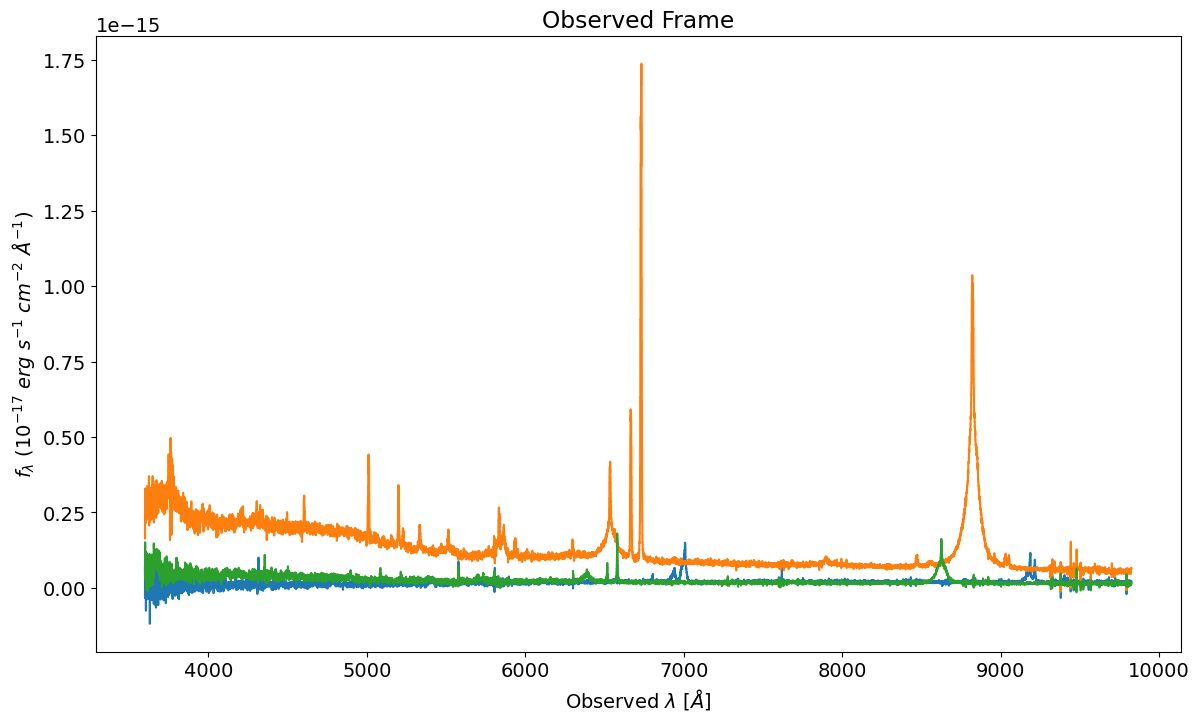

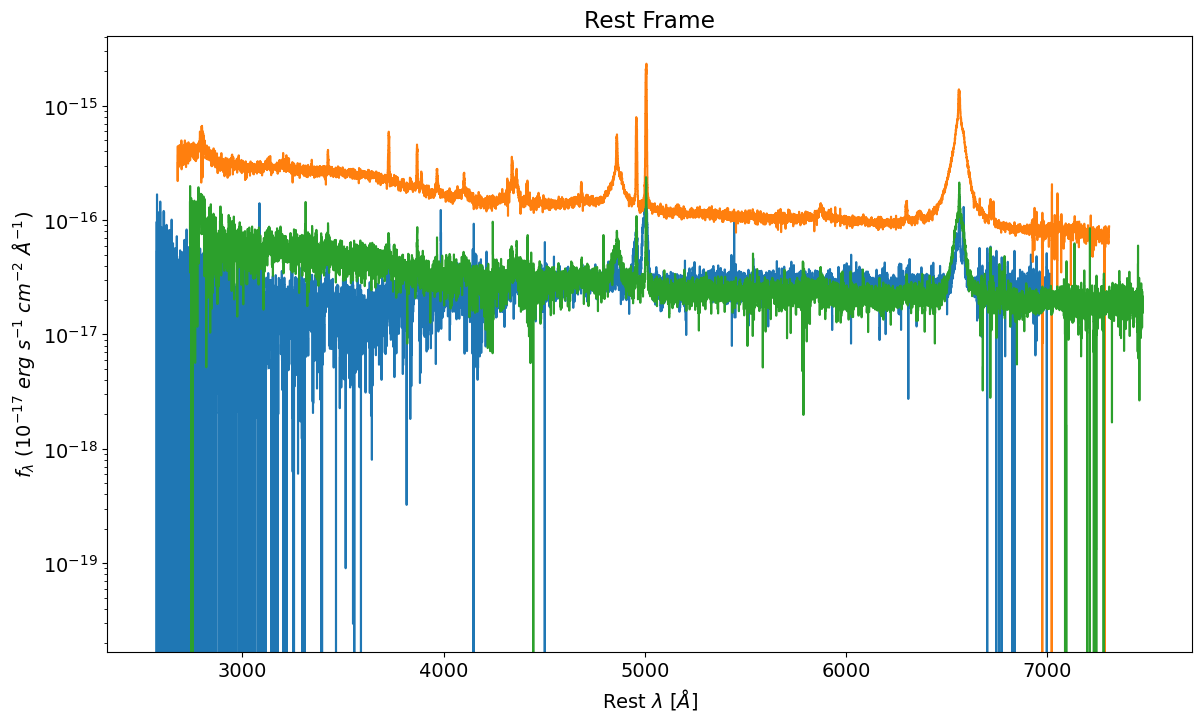

In [80]:
# Plot a couple of examples
f, ax = plt.subplots()  
for i in range(3):
    valid = specs[i].mask==0
    ax.step(specs[i].spectral_axis[valid], specs[i].flux[valid]) 
plt.title('Observed Frame')
plt.xlabel('Observed $\lambda\ [\AA]$')
plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
plt.show()

# Same two spectra in rest-frame
f, ax = plt.subplots()
for i in range(3):
    valid = specs[i].mask==0
    ax.step(specs[i].spectral_axis[valid]/(1.+specs[i].redshift), specs[i].flux[valid]*(1.+specs[i].redshift)) 
plt.title('Rest Frame')
plt.xlabel('Rest $\lambda\ [\AA]$')
plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
plt.show()

<a class="anchor" id="plot"></a>
## Plot spectra function

In [64]:
def plot_spec(index, results):
    """
    Pass an index value and the output from using client.retrieve()
    to plot the spectrum at the specified index.
    """
    
    record = results.loc[index]

    # We renamed specid to targetid for DESI (specid=specobjid for SDSS/BOSS) 
    specid = record.targetid
    data_release = record.data_release

    # Spectra quantities
    wavelength = record.wavelength
    model = record.model
    flux = record.flux
    # Special case with mask (.mask is a reserved syntax)
    mask = results['mask'].loc[index]

    # Round the redshift, RA, Dec to a reasonable number of significant digits
    redshift = np.round(record.redshift, 4)
    ra = np.round(record.ra, 7)
    dec = np.round(record.dec, 7)

    plt.title(f"Data Set = {data_release}\n"
              f"SpecID = {specid}\n"
              f"Redshift = {redshift}\n"
              f"RA = {ra}\n"
              f"Dec = {dec}", loc='left')
    plt.xlabel('$\lambda\ [\AA]$')
    plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
    
    # Plot unsmoothed spectrum in grey
    plt.plot(wavelength[mask==0], flux[mask==0], color='k', alpha=0.2, label='Unsmoothed spectrum')
    
    # Overplot spectrum smoothed using a 1-D Gaussian Kernel in black
    plt.plot(wavelength[mask==0], convolve(flux[mask==0], Gaussian1DKernel(5)), color='k', label='Smoothed spectrum')
    
    # Overplot the model spectrum in red
    plt.plot(wavelength[mask==0], model[mask==0], color='r', label='Model spectrum')
    
    plt.legend()
    plt.show()

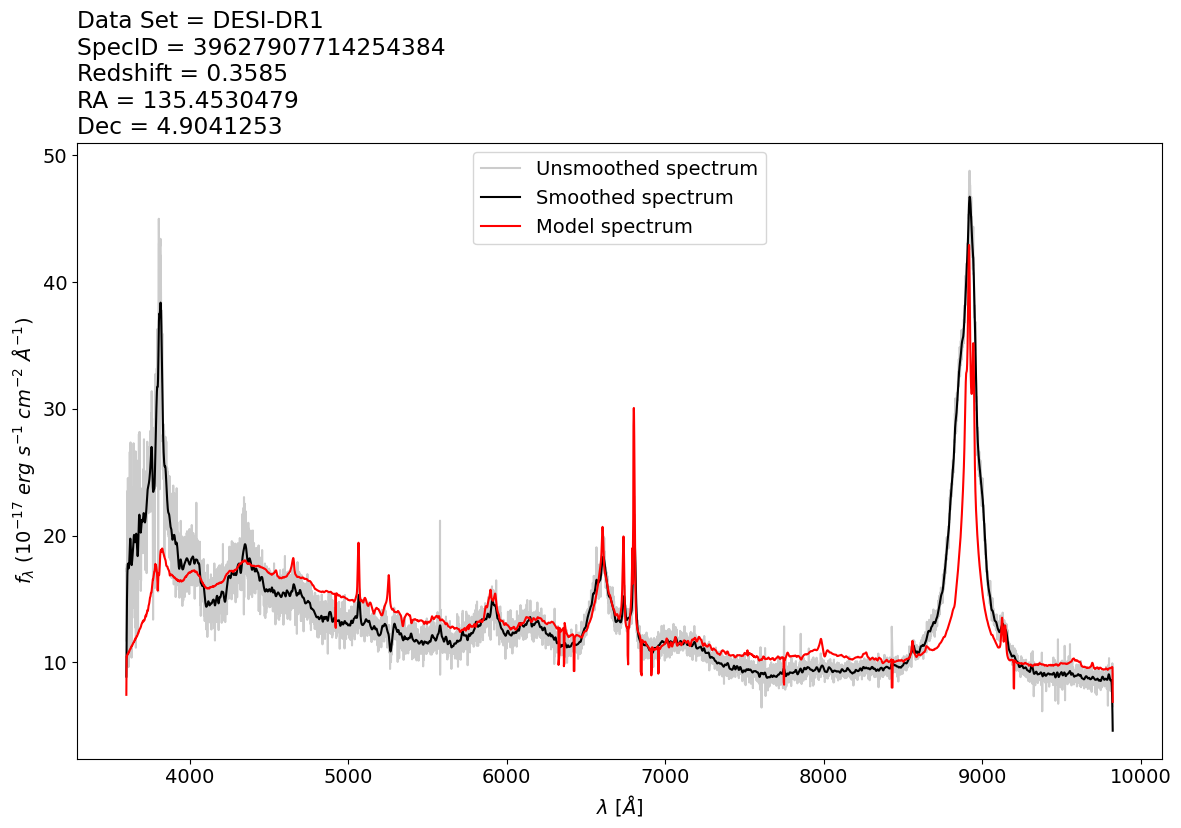

In [66]:
plot_spec(index=3, results=df_join)

<a class="anchor" id="additionalacknowledgments"></a>
## Additional acknowledgments

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you are using the Astro Data Lab in your research, please cite the following papers:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`